### Boiler Plate Code

In [1]:
import random
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from time import time
from QAP_heuristic import QAP_heuristic
%matplotlib inline

In [2]:
# set up params for plots
SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=SMALL)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=SMALL)       # controls default text sizes

##### Iterated Local Search

We closely follow the paper: ILS for QAP (Sultze '05) to implement the below method

In [11]:
class IteratedLocalSearch(QAP_heuristic):
    def __init__(self, w, d) -> None:
        super().__init__(w, d)
    
    # Subroutines
    def generate_initial_solution(self):
        return np.random.permutation(self.n)
    
    
    def local_search(self, perm: np.array):
        n = len(perm)
        curr_best = np.copy(perm)  # create a deep copy
        
        for i in range(1, n-2):
            for j in range(i+1, n):
                
                new_perm = np.copy(curr_best)
                new_perm[i:j] = curr_best[j-1:i-1:-1]
                
                if self.cost(new_perm) < self.cost(curr_best): 
                    curr_best = new_perm        
        
        return curr_best
    
    
    def acceptance_criterion(self, perm1: np.array, perm2: np.array):
        return perm1 if self.cost(perm1) < self.cost(perm2) else perm2
    
    @staticmethod
    def peturbation(perm: np.array, k: int):
        new_perm = perm[:]
        # of course, this inexact method can result in pertubations of size < k, but these occur with sufficiently small probability 
        for _ in range(k): 
            i = random.randint(0, len(perm)-1)
            j = random.randint(0, len(perm)-1)
            new_perm[i], new_perm[j] = new_perm[j], new_perm[i]   
        
        return new_perm
    

    # ILS implementation
    def solve(self, n_iters: int):
        s0 = self.generate_initial_solution()
        s  = self.local_search(s0)
        
        curr_best = s
        cost_history = [self.cost(s)]
        perm_history = [s]
        n = len(s0)

        for _ in range(n_iters):
            
            if time() > self.MAX_CPU_TIME: break
            
            s1 = self.peturbation(s, k=n//2)
            s2 = self.local_search(s1)
            curr_best = self.acceptance_criterion(curr_best, s2)
            
            cost_history.append(self.cost(curr_best))
            perm_history.append(curr_best)

        return curr_best, cost_history, perm_history

### Verification

we verify the correctness of our implementation by plotting cost history on the following test instance 

In [10]:
# for managing file opening and closing
def read_integers(filename):
    with open(filename) as f:
        return [int(elem) for elem in f.read().split()]

file_path = '../QAPInstances/tai15b.dat'
file_it = iter(read_integers(file_path))

# Number of points
n = next(file_it)

# Distance between locations
w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

ils = IteratedLocalSearch(w, d)
soln, cost_hist, perm_hist = ils.solve(100_000)
print(ils.cost(soln))

402207785


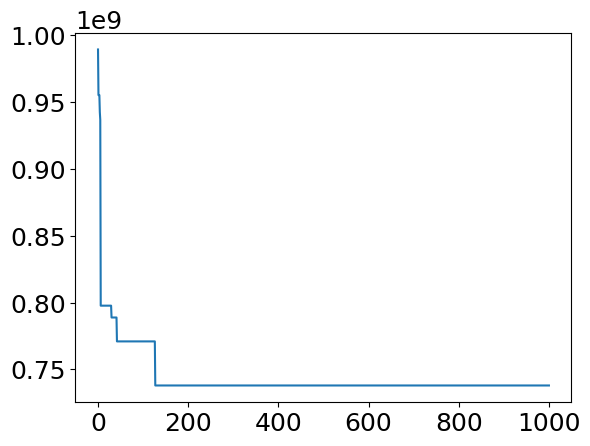

In [9]:
plt.plot(cost_hist)

### Automated Testing
code for automating the opening, closing and testing of a hueristic on every instance in QAPLib

In [6]:
import csv

instance_path = '../QAPInstances/'
soln_path     = '../QAPSolns/'

def open_solution(filename: str):
    file_it = iter(read_integers(filename))
    _ = next(file_it)    # this is just how the files within the lib are formatted
    return next(file_it)

        

def test_hueristic(n_iters=10_000, tai_only=False):
    """
    n_iters: number of iterations on each test instance
    tai_only: if True, restricts testing to the Tai instances, reducing computation time
    """

    with open('../results/ils.csv', mode='w') as f: 
        writer = csv.writer(f)

        for filename in os.listdir(instance_path):
            
            # skips any instances that are not Tai
            if tai_only and 'tai' not in filename: continue  

            file_it = iter(read_integers(instance_path+filename))

            # open QAP instance param's 
            n = next(file_it)
            w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
            d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

            # generate an instance
            ils = IteratedLocalSearch(w, d)

            # open up corresponding soln from QAPLib: 
            soln_file = filename[:-4]+'.sln' # this removes the .dat from filename
            
            try:
                qap_soln = open_solution(soln_path+soln_file)
                huerstic_soln, _, _ = ils.solve(n_iters)

                # compute gap
                gap = 100*(ils.cost(huerstic_soln) - qap_soln)/qap_soln
                print(filename, gap)
                writer.writerow([filename, gap])

            # any instances without corresponding solution files are deleted
            except FileNotFoundError:
                os.remove(instance_path+filename) 
        
    return

In [12]:
test_hueristic(100_000, tai_only=True)

tai35b.dat 13.698265902870208
tai15a.dat 2.976193542736738
tai35a.dat 8.57637607235667
tai15b.dat 0.43946454599636187
tai80b.dat 20.56360259252957
tai150b.dat 16.21372625672288
tai80a.dat 8.697014575103207
tai100a.dat 8.531570600802775
tai25a.dat 6.904569348968864
tai100b.dat 20.381018913892127
tai25b.dat 7.469208447362004
tai64c.dat 0.43751697264118006
tai12a.dat 0.0
tai12b.dat 0.028957358971289062
tai50b.dat 19.727266626861354
tai50a.dat 9.265173131265191
tai30b.dat 14.683912437931957
tai30a.dat 8.473466927298468
tai40a.dat 9.390227975676648
tai17a.dat 3.5440371524078307
tai256c.dat 9.71946965919525
tai60b.dat 18.54771980043756
tai40b.dat 18.057169528133837
tai60a.dat 9.412761266295881
tai20a.dat 6.107050358075971
tai20b.dat 3.6189689726748413
